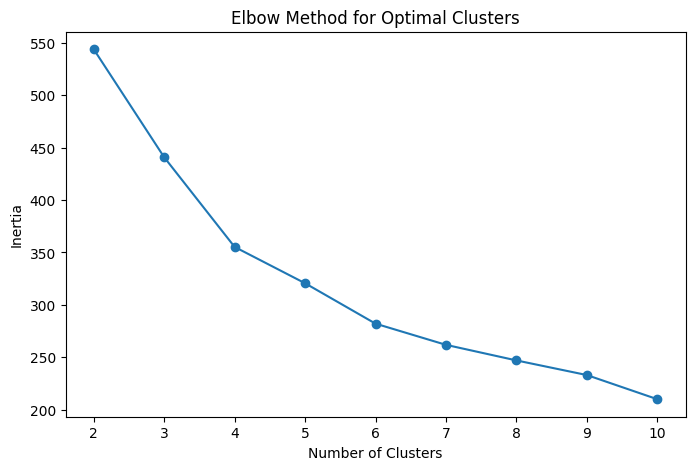

Number of Clusters: 4
Davies-Bouldin Index: 1.2065
Silhouette Score: 0.2635


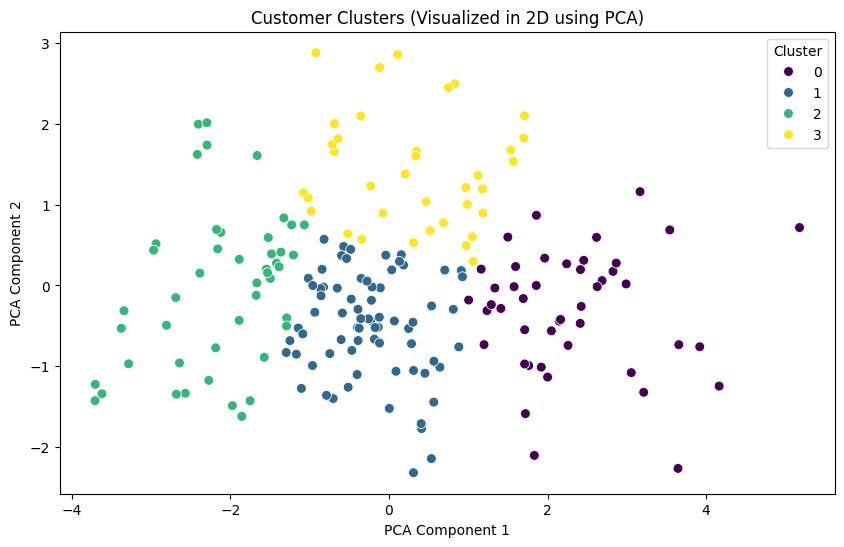

Clustering results saved to 'Customer_Clusters.csv'


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')

# Merge customers and transaction data
data = transactions.merge(customers, on="CustomerID", how="left")

# Feature Engineering
# Aggregate transaction data for each customer
customer_features = data.groupby("CustomerID").agg(
    total_spending=pd.NamedAgg(column="TotalValue", aggfunc="sum"),
    avg_spending=pd.NamedAgg(column="TotalValue", aggfunc="mean"),
    total_transactions=pd.NamedAgg(column="TransactionID", aggfunc="count"),
    total_quantity=pd.NamedAgg(column="Quantity", aggfunc="sum")
).reset_index()

# Add customer profile information
customer_features = customer_features.merge(customers[["CustomerID", "Region"]], on="CustomerID", how="left")

# Encode categorical features (Region)
customer_features = pd.get_dummies(customer_features, columns=["Region"], drop_first=True)

# Normalize numerical features
scaler = StandardScaler()
numerical_cols = ["total_spending", "avg_spending", "total_transactions", "total_quantity"]
customer_features[numerical_cols] = scaler.fit_transform(customer_features[numerical_cols])

# Prepare data for clustering (excluding CustomerID)
clustering_data = customer_features.drop(columns=["CustomerID"])

# Determine optimal number of clusters using Elbow Method
inertia = []
for k in range(2, 11):  # Testing clusters from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# Select optimal number of clusters (e.g., based on the Elbow Curve, choose 4 clusters)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features["Cluster"] = kmeans.fit_predict(clustering_data)

# Evaluate clustering metrics
db_index = davies_bouldin_score(clustering_data, customer_features["Cluster"])
silhouette_avg = silhouette_score(clustering_data, customer_features["Cluster"])

print(f"Number of Clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Visualize Clusters
# Using PCA to reduce dimensionality to 2D for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(clustering_data)
customer_features["PCA1"] = pca_data[:, 0]
customer_features["PCA2"] = pca_data[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1", y="PCA2", hue="Cluster", palette="viridis", data=customer_features, s=50
)
plt.title("Customer Clusters (Visualized in 2D using PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Save clustering results to a CSV
customer_features[["CustomerID", "Cluster"]].to_csv("Customer_Clusters.csv", index=False)
print("Clustering results saved to 'Customer_Clusters.csv'")


In [2]:
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=2547fb9d972e670fc6513b642706378b7b2b02468dd26196fbe71f74565ec380
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [4]:
from fpdf import FPDF
import matplotlib.pyplot as plt

# Initialize PDF
class PDF(FPDF):
    def header(self):
        self.set_font("Arial", "B", 12)
        self.cell(0, 10, "Customer Segmentation Report", border=False, ln=1, align="C")

    def footer(self):
        self.set_y(-15)
        self.set_font("Arial", "I", 10)
        self.cell(0, 10, f"Page {self.page_no()}", align="C")

    def chapter_title(self, title):
        self.set_font("Arial", "B", 12)
        self.cell(0, 10, title, ln=1, border=False, align="L")
        self.ln(5)

    def chapter_body(self, body):
        self.set_font("Arial", "", 11)
        self.multi_cell(0, 10, body)
        self.ln()

# Initialize the PDF
pdf = PDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()

# Add Introduction
pdf.chapter_title("Introduction")
pdf.chapter_body(
    "This report details the results of customer segmentation using clustering techniques. "
    "The task aimed to group customers based on profile and transaction data, evaluate the clusters using metrics "
    "like Davies-Bouldin Index and Silhouette Score, and visualize the clusters. The following sections outline "
    "the methodology, metrics, and insights derived from the clustering analysis."
)

# Add Dataset Description
pdf.chapter_title("Dataset and Features")
pdf.chapter_body(
    "The dataset contains customer profiles (CustomerID, Region, SignupDate) and transactions "
    "(TransactionID, ProductID, TotalValue, Quantity). Features such as total spending, average spending, "
    "transaction count, and total quantity purchased were used for clustering, along with encoded region information."
)

# Add Clustering Metrics
pdf.chapter_title("Clustering Results and Metrics")
pdf.chapter_body(
    f"Optimal Number of Clusters: {optimal_clusters}\n"
    f"Davies-Bouldin Index: {db_index:.4f}\n"
    f"Silhouette Score: {silhouette_avg:.4f}\n\n"
    "A lower Davies-Bouldin Index indicates better-defined clusters, while a higher Silhouette Score indicates "
    "better-separated clusters."
)

# Add Elbow Curve Plot
pdf.chapter_title("Elbow Curve")
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker="o", color="blue", label="Inertia")
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.legend()
plt.savefig("elbow_curve.png", bbox_inches="tight")
plt.close()
pdf.image("elbow_curve.png", x=10, y=None, w=180)

# Add Cluster Visualization
pdf.chapter_title("Cluster Visualization")
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1",
    y="PCA2",
    hue="Cluster",
    palette="viridis",
    data=customer_features,
    s=50
)
plt.title("Customer Clusters (PCA 2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.savefig("clusters_pca.png", bbox_inches="tight")
plt.close()
pdf.image("clusters_pca.png", x=10, y=None, w=180)

# Add Cluster Summary
pdf.chapter_title("Cluster Summary")
cluster_counts = customer_features["Cluster"].value_counts()
summary_text = "The following table summarizes the number of customers in each cluster:\n\n"
summary_text += "\n".join(
    [f"Cluster {cluster}: {count} customers" for cluster, count in cluster_counts.items()]
)
pdf.chapter_body(summary_text)

# Save PDF
pdf.output("Customer_Segmentation_Report.pdf")
print("Customer Segmentation Report generated: 'Basavaraj_kalburgi_clustering.pdf'")


Customer Segmentation Report generated: 'Basavaraj_kalburgi_clustering.pdf'
